## TRAIN THE MODEL AND EVALUATE IT 


In [1]:
# Importing libraries
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA 

from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier  
from sklearn.metrics import make_scorer, accuracy_score 
from sklearn.svm import SVC 
from sklearn.model_selection import KFold



## DEFINE FUNCTIONS

In [2]:
#function for merging left and right dataframe
def merge(left, right, name ):
    pvs= pd.concat([left, right], axis=1)
    length= len(left)

    # Renaming labels
    pvs.columns = [
    'timestamp', 'acc_x_dashboard_l', 'acc_y_dashboard_l', 'acc_z_dashboard_l',
    'acc_x_above_suspension_l', 'acc_y_above_suspension_l', 'acc_z_above_suspension_l', 
    'acc_x_below_suspension_l', 'acc_y_below_suspension_l', 'acc_z_below_suspension_l', 
    'gyro_x_dashboard_l', 'gyro_y_dashboard_l', 'gyro_z_dashboard_l', 'gyro_x_above_suspension_l', 
    'gyro_y_above_suspension_l', 'gyro_z_above_suspension_l', 'gyro_x_below_suspension_l', 
    'gyro_y_below_suspension_l', 'gyro_z_below_suspension_l', 'mag_x_dashboard_l', 'mag_y_dashboard_l', 
    'mag_z_dashboard_l', 'mag_x_above_suspension_l', 'mag_y_above_suspension_l', 'mag_z_above_suspension_l', 
    'temp_dashboard_l', 'temp_above_suspension_l', 'temp_below_suspension_l', 'timestamp_gps', 
    'latitude', 'longitude', 'speed', 'timestamp', 'acc_x_dashboard_r', 'acc_y_dashboard_r', 
    'acc_z_dashboard_r', 'acc_x_above_suspension_r', 'acc_y_above_suspension_r', 
    'acc_z_above_suspension_r', 'acc_x_below_suspension_r', 'acc_y_below_suspension_r', 
    'acc_z_below_suspension_r', 'gyro_x_dashboard_r', 'gyro_y_dashboard_r', 'gyro_z_dashboard_r', 
    'gyro_x_above_suspension_r', 'gyro_y_above_suspension_r', 'gyro_z_above_suspension_r', 
    'gyro_x_below_suspension_r', 'gyro_y_below_suspension_r', 'gyro_z_below_suspension_r', 
    'mag_x_dashboard_r', 'mag_y_dashboard_r', 'mag_z_dashboard_r', 'mag_x_above_suspension_r', 
    'mag_y_above_suspension_r', 'mag_z_above_suspension_r', 'temp_dashboard_r', 'temp_above_suspension_r', 
    'temp_below_suspension_r', 'timestamp_gps', 'latitude', 'longitude', 'speed'
    ]
    

    # Remove duplicate columns (those with the same name, e.g., 'timestamp_gps', 'latitude', etc.)
    pvs_removed = pvs.loc[:, ~pvs.columns.duplicated()]

    # Columns to keep. We try these first
    to_keep=["timestamp",
             "acc_x_dashboard_l",
             "acc_y_dashboard_l",
             "acc_z_dashboard_l",
             "speed",
             "gyro_x_dashboard_l",
             "gyro_y_dashboard_l",
             "gyro_z_dashboard_l"
            ]
    
    pvs_removed=pvs_removed[to_keep]

    #create the driver column ( target )
    if name in ("pvs1_gps_mpu","pvs2_gps_mpu","pvs3_gps_mpu"):
        pvs_removed['Driver'] = 1
    elif name in ("pvs4_gps_mpu","pvs5_gps_mpu","pvs6_gps_mpu"):
        pvs_removed['Driver'] = 2
    else: 
        pvs_removed['Driver'] = 3
        
    return pvs_removed

#Drivers do not drive in the start and end of each route. Function for removing these indicies
def remove_zero_values(dfs):

    new = dfs

    non_zero_indices = {}
    threshold = 0.1  # Define the threshold to detect non-zero speeds

    for key, df in new.items():

        first_non_zero_index = (df['speed'].abs() > threshold).idxmax()
        last_non_zero_index = (df['speed'][::-1].abs() > threshold).idxmax()

        non_zero_indices[key] = (first_non_zero_index, last_non_zero_index)

    # Iterate through each dataset and its respective non-zero index
    for key, index in non_zero_indices.items():
        new[key] = new[key].iloc[index[0]:index[1]].reset_index(drop=True)  # Remove rows up to the index and reset index

    return new

#Function for making dfs equal size in order to avoid bias. Each route is truncated to the same length
def equalize_dfs(dfs):

    new = dfs

    # Split DataFrames into three routes
    dfs_keys = list(new.keys())  # Get all keys in the dictionary
    first_route_keys = dfs_keys[:3]  # First three keys for the first route
    second_route_keys = dfs_keys[3:6]  # Next three keys for the second route
    third_route_keys = dfs_keys[6:]  # Last three keys for the third route

    # Calculate the minimum lengths for each route
    min_length_first_route = min(len(new[key]) for key in first_route_keys)
    min_length_second_route = min(len(new[key]) for key in second_route_keys)
    min_length_third_route = min(len(new[key]) for key in third_route_keys)

    # Truncate all DataFrames in each route to the respective minimum length
    for key in first_route_keys:
        new[key] = new[key].iloc[:min_length_first_route].reset_index(drop=True)

    for key in second_route_keys:
        new[key] = new[key].iloc[:min_length_second_route].reset_index(drop=True)

    for key in third_route_keys:
        new[key] = new[key].iloc[:min_length_third_route].reset_index(drop=True)

    return new

#Need to make the ratio between dfs and ratio to be an integer in order for dataframe reduction to work
def round_dfs(dfs, ratio):

    new = dfs

    for key, df in new.items():

        rounded_length = len(df) - (len(df) % ratio)

        new[key] = df.iloc[:rounded_length].reset_index(drop=True)

    return new


def reduce_df(df, ratio, name):
    new = pd.DataFrame()
    print(f"Reducing {name}")
    
    # Iterate in steps of 'ratio' through the DataFrame
    for i in range(0, len(df) - ratio + 1, ratio):
        # Select the rows from i to i+ratio (inclusive of i, exclusive of i+ratio)
        subset = df.iloc[i:i+ratio]
        
        # Calculate the mean for each column in the selected rows
        merged_row = subset.mean(axis=0)
        
        # Append the result as a new row to the DataFrame `new`
        new = pd.concat([new, merged_row.to_frame().T], ignore_index=True)
        
    return new


#helping function for reduction

def delete_timestamp(df):
    to_remove=["timestamp_max","timestamp_min","timestamp_mean","timestamp_STD_"]
    new= df.drop(columns=to_remove, axis=1, errors='ignore')

    return new

def update_name(df):
    new_column_names = [ 'timestamp_max','acc_x_dashboard_l_max', 'acc_y_dashboard_l_max', 
        'acc_z_dashboard_l_max', 'speed_max', 'gyro_x_dashboard_l_max', 
        'gyro_y_dashboard_l_max', 'gyro_z_dashboard_l_max', 
        'timestamp_min', 'acc_x_dashboard_l_min', 'acc_y_dashboard_l_min', 
        'acc_z_dashboard_l_min', 'speed_min', 'gyro_x_dashboard_l_min', 
        'gyro_y_dashboard_l_min', 'gyro_z_dashboard_l_min', 
        'timestamp_mean', 'acc_x_dashboard_l_mean', 'acc_y_dashboard_l_mean', 
        'acc_z_dashboard_l_mean', 'speed_mean', 'gyro_x_dashboard_l_mean', 
        'gyro_y_dashboard_l_mean', 'gyro_z_dashboard_l_mean', 
        'timestamp_STD_', 'acc_x_dashboard_l_STD_', 'acc_y_dashboard_l_STD_', 
        'acc_z_dashboard_l_STD_', 'speed_STD_', 'gyro_x_dashboard_l_STD_', 
        'gyro_y_dashboard_l_STD_', 'gyro_z_dashboard_l_STD_']
        #,
        # 'acc_x_dashboard_l_jerk', 'acc_y_dashboard_l_jerk', 
        #'acc_z_dashboard_l_jerk', 'speed_jerk', 'gyro_x_dashboard_l_jerk', 
        #'gyro_y_dashboard_l_jerk', 'gyro_z_dashboard_l_jerk'
        #]
    df.columns = new_column_names
    return df



#function for computing the rolling window and the aggregation functions, 
#--> returns a dictionary containing the 9 dataframes windowed (still separated)
def computeWindow(name,df, windowSize=100, show=False):
    if show:
        print("--------------------------")
        print(f"computing dataset {name}")
    
    #define empty dataframe  

    X= df.iloc[:, :-1]
    Y= df.iloc[:len(df)-windowSize+1, -1]
    windowed_df=pd.DataFrame()

    #define starting and ending index
    for start_idx in range(len(df)-windowSize+1):
        end_idx=start_idx+windowSize

        #extract rows belonging to the window
        window=X.iloc[start_idx:end_idx]

        #take beginning timestamp and ending timestamp
        start_timestamp=window.iloc[0,0]
        end_timestamp=window.iloc[-1,0]

        
        #keep only sensor data
        sensor_data_window=window.iloc[:,1:]

        #compute metrics for the specific window
        max_values=window.max()
        min_values=window.min()
        mean_values=window.mean()
        std_values=window.std()
        #jerk_values=(sensor_data_window.iloc[-1]-sensor_data_window.iloc[0])/(end_timestamp-start_timestamp)

        #concate them (place side by side)
        new_row=pd.concat([max_values,min_values,mean_values,std_values,])#jerk_values])
        new_row = new_row.to_frame().T 

        windowed_df = pd.concat([windowed_df, new_row], ignore_index=True)

        
        if show and start_idx%10000==0:
            print(start_idx)

    #place aside again  X and Y
    final=pd.concat([delete_timestamp(update_name(windowed_df)),Y], axis=1)  
    return final


#define train_test splits, based on the track we define in test_track. 
#we use test_track for testing and the other two tracks for training
#-->returns X_train,y_train,X_test,y_test as numpy arrays

def train_test_my_split(dfs,test_track,numpy_conversion=True):
    #take track three for testing and trcakk 1,2 for trainig
    all_keys=list(dfs.keys())

    if test_track==3:
        train_indices=[0,1,3,4,6,7]
        test_indices=[2,5,8]
    elif test_track==2:
        train_indices=[0,2,3,5,6,8]
        test_indices=[1,4,7]
    elif test_track==1:
        train_indices=[1,2,4,5,7,8]
        test_indices=[0,3,6]
        

    train_dfs = [dfs[all_keys[i]] for i in train_indices]
    train_df = pd.concat(train_dfs, axis=0, ignore_index=True)

    # Shuffle the training data
    train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

    test_dfs = [dfs[all_keys[i]] for i in test_indices]
    test_df = pd.concat(test_dfs, axis=0, ignore_index=True)

    
    # Shuffle testing data
    test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)


    if numpy_conversion:
        #split features and targets
        X_train=train_df.iloc[:,:-1].to_numpy()
        y_train=train_df.iloc[:,-1].to_numpy()
    
        X_test=test_df.iloc[:,:-1].to_numpy()
        y_test=test_df.iloc[:,-1].to_numpy()
    else:
        #split features and targets
        X_train=train_df.iloc[:,:-1]
        y_train=train_df.iloc[:,-1]
    
        X_test=test_df.iloc[:,:-1]
        y_test=test_df.iloc[:,-1]
        
    return X_train,y_train,X_test,y_test

#function for creating the model based on the parameter type
#--> returns the model
def create_model(type):
    if type=="RandomForest":
        return RandomForestClassifier(n_estimators=100, random_state=42)
    elif type == "SVM":
        return SVC(kernel="rbf", C=1.0)
    elif type == "lr":
        return LogisticRegression(random_state=42, max_iter=1000)

#test the model on the TEST set, take as input the NON-WINDOWED datasets
#-->returns the accuracy on the test set

def test_model(X_train,y_train,X_test,y_test,model_type,test_track=3):
    #create the  model 
    model=create_model(model_type)
    
    model.fit(X_train, y_train)

    # Test set evaluation
    y_test_pred = model.predict(X_test)

    
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Test set accuracy: {test_accuracy:.4f}")
    

# function for cross-fold evaluation, with num_folds folds, taken as a parameter
#--> returns average accuracy for the specific hyperparameters configuration defined as input

def evaluate_model(X_train,y_train,model_type,num_folds,test_track=3):
    
    #create the  model 
    model=create_model(model_type)

    #APPLY CROSS-FOLDER EVALUATION

    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    fold_accuracies = []
    
    for train_index, val_index in kf.split(X_train):
        X_ttrain, X_val = X_train[train_index], X_train[val_index] 
        y_ttrain, y_val = y_train[train_index], y_train[val_index]
            
        model.fit(X_ttrain, y_ttrain) 
        y_pred = model.predict(X_val) 
        
        accuracy = accuracy_score(y_val, y_pred) 
        print((y_val != y_pred).sum())
        print('accuracy:', accuracy)
        fold_accuracies.append(accuracy)

    average_accuracy = sum(fold_accuracies) / num_folds
    print('average of fold',average_accuracy)

    return average_accuracy

#intermediate function, used for: 
#windowing based on the window size
#-->returns X_train,y_train,X_test,y_test based on track defined in test_track


def window_and_split(dfs,window_size,test_track=3):
    dfs_windowed={name:computeWindow(name,dfs[name]) for name in dfs.keys()}

    return train_test_my_split(dfs_windowed,test_track)

#main function, takes hyperparameters options, model type and num_folds for k-fold
#tries all configurations on the evaluation set
#test the best configuration on the trainig set 

def tuning_and_evaluation(dfs,window_sizes,model_type,num_folds,test_track=3):

    #initialize optimal results
    best_accuracy=0
    best_window_size=0


    #store all the average accuracies with different hyperparameters inside an arrray
    tot_accuracies=[]

    for window_size in window_sizes:
        print(f"--------------------")
        print(f"EVALUATE window_size: {window_size}")
        
        X_train,y_train,X_test,y_test=window_and_split(datasets_reduced,window_size)
        
        accuracy=evaluate_model(X_train,y_train,model_type,num_folds,test_track)
        tot_accuracies.append(accuracy)
        
        
        #update optimal results if needed
        if accuracy>best_accuracy:
            best_accuracy=accuracy
            best_window_size=window_size
            
            
    print(f"Best window size: {best_window_size} with accuracy: {best_accuracy}")
    print("test best model on TEST data")
    
    X_train,y_train,X_test,y_test=window_and_split(datasets_reduced,best_window_size)
    
    test_model(X_train,y_train,X_test,y_test,model_type,test_track)


## IMPORT THE DATA 

In [4]:
# Importing datasets
filepaths_left={
    "pvs1_gps_mpu" : r"../archive/PVS 1/dataset_gps_mpu_left.csv",
    "pvs2_gps_mpu" : r"../archive/PVS 2/dataset_gps_mpu_left.csv",
    "pvs3_gps_mpu" : r"../archive/PVS 3/dataset_gps_mpu_left.csv",
    "pvs4_gps_mpu" : r"../archive/PVS 4/dataset_gps_mpu_left.csv",
    "pvs5_gps_mpu" : r"../archive/PVS 5/dataset_gps_mpu_left.csv",
    "pvs6_gps_mpu" : r"../archive/PVS 6/dataset_gps_mpu_left.csv",
    "pvs7_gps_mpu" : r"../archive/PVS 7/dataset_gps_mpu_left.csv",
    "pvs8_gps_mpu" : r"../archive/PVS 8/dataset_gps_mpu_left.csv",
    "pvs9_gps_mpu" : r"../archive/PVS 9/dataset_gps_mpu_left.csv"
}

filepaths_right={
    "pvs1_gps_mpu" : r"../archive/PVS 1/dataset_gps_mpu_right.csv",
    "pvs2_gps_mpu" : r"../archive/PVS 2/dataset_gps_mpu_right.csv",
    "pvs3_gps_mpu" : r"../archive/PVS 3/dataset_gps_mpu_right.csv",
    "pvs4_gps_mpu" : r"../archive/PVS 4/dataset_gps_mpu_right.csv",
    "pvs5_gps_mpu" : r"../archive/PVS 5/dataset_gps_mpu_right.csv",
    "pvs6_gps_mpu" : r"../archive/PVS 6/dataset_gps_mpu_right.csv",
    "pvs7_gps_mpu" : r"../archive/PVS 7/dataset_gps_mpu_right.csv",
    "pvs8_gps_mpu" : r"../archive/PVS 8/dataset_gps_mpu_right.csv",
    "pvs9_gps_mpu" : r"../archive/PVS 9/dataset_gps_mpu_right.csv"


}

# Left and right corresponds to sensordata from either side of the cars
datasets_left = {name:pd.read_csv(path) for name,path in filepaths_left.items()}
datasets_right = {name:pd.read_csv(path) for name,path in filepaths_right.items()}

datasets = {name: merge(datasets_left[name],datasets_right[name], name) for name in datasets_right.keys()}



# PREPROCESS THE DATA

In [5]:
datasets_rm_zeros = remove_zero_values(datasets)
equalized_datasets = equalize_dfs(datasets_rm_zeros)   

## REDUCE THE DATA 


In [7]:
#REDUCE THE DATA
ratio=20
rounded_datasets = round_dfs(equalized_datasets, ratio)

#for key, index in rounded_datasets.items():
#    print("Length of speed list for", key, ": ", len(rounded_datasets[key]['speed']))

datasets_reduced={name:reduce_df(rounded_datasets[name],ratio,name) for name in rounded_datasets.keys()}

Reducing pvs1_gps_mpu
Reducing pvs2_gps_mpu
Reducing pvs3_gps_mpu
Reducing pvs4_gps_mpu
Reducing pvs5_gps_mpu
Reducing pvs6_gps_mpu
Reducing pvs7_gps_mpu
Reducing pvs8_gps_mpu
Reducing pvs9_gps_mpu


## PCA 

In [8]:
#create the full df
test_track=3
dfs_windowed={name:computeWindow(name,datasets_reduced[name],100,True) for name in datasets_reduced.keys()}
X_train,y_train,X_test,y_test=train_test_my_split(dfs_windowed,test_track,numpy_conversion=False)

--------------------------
computing dataset pvs1_gps_mpu
0
--------------------------
computing dataset pvs2_gps_mpu
0
--------------------------
computing dataset pvs3_gps_mpu
0
--------------------------
computing dataset pvs4_gps_mpu
0
--------------------------
computing dataset pvs5_gps_mpu
0
--------------------------
computing dataset pvs6_gps_mpu
0
--------------------------
computing dataset pvs7_gps_mpu
0
--------------------------
computing dataset pvs8_gps_mpu
0
--------------------------
computing dataset pvs9_gps_mpu
0


In [10]:
#START APPLYING PCA
#apply standard scaler
scaler= StandardScaler()
X_train_scaled_values=scaler.fit_transform(X_train)
X_test_scaled_values=scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled_values, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled_values, columns=X_train.columns)

In [8]:
len(X_train_scaled)

275600

In [9]:
#apply PCA
pca=PCA()
pca_non_scaled=PCA()

#fitting the objects
pca.fit(X_train_scaled)
pca_non_scaled.fit(X_train)



PCA()

## Cumulative Explained Variance

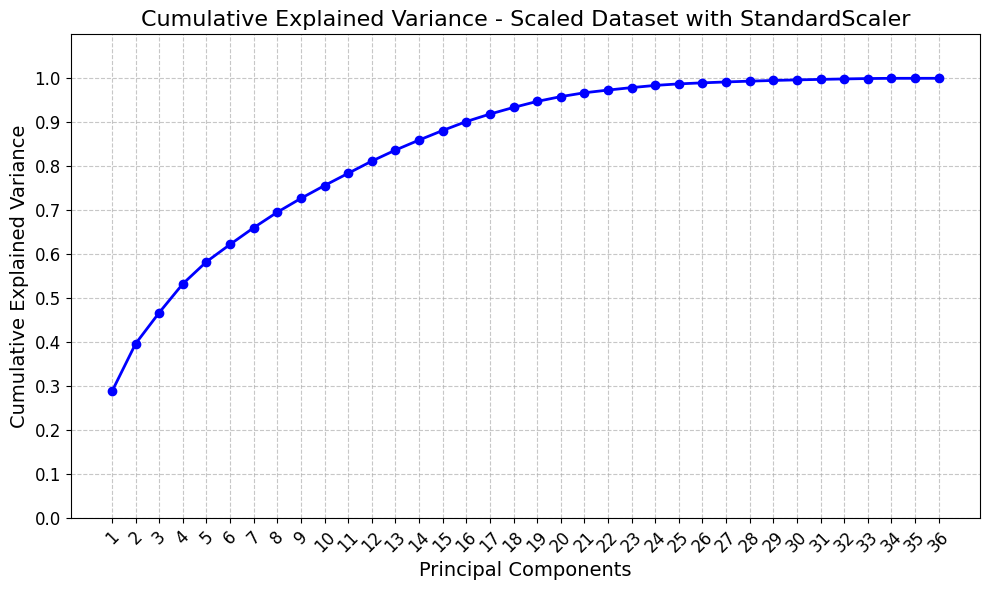

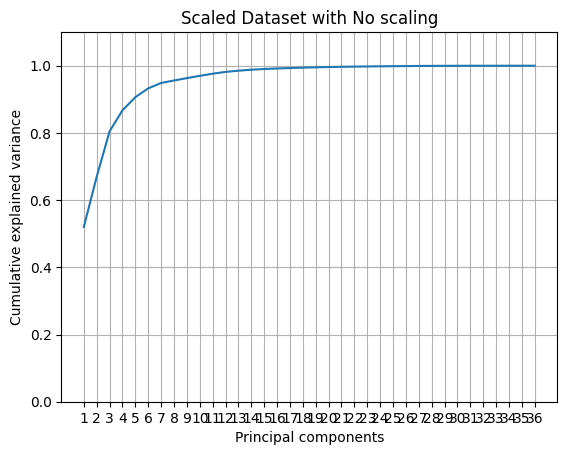

In [14]:
# Assuming pca.explained_variance_ratio_ and pca.n_features_in_ are already defined

plt.figure(figsize=(10, 6))  # Increase figure size
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', color='b', linestyle='-', linewidth=2, markersize=6)  # Add markers to points for clarity

plt.title('Cumulative Explained Variance - Scaled Dataset with StandardScaler', fontsize=16)
plt.ylim([0, 1.1])
plt.xlabel('Principal Components', fontsize=14)
plt.ylabel('Cumulative Explained Variance', fontsize=14)

# Make x-ticks distinguishable and rotate them
plt.xticks(
    ticks=np.arange(pca.n_features_in_),
    labels=[f'{i + 1}' for i in range(pca.n_features_in_)],
    rotation=45,  # Rotate labels to avoid overlap
    fontsize=12
)

# Manually set the y-ticks to include all decimal numbers from 0.1 to 1.0
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=12)

# Add dashed grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Save the figure to the gallery (current working directory)
plt.tight_layout()  # Adjust layout for better fit

# Save to a file
plt.savefig('plot_cumulative_variance.png')

# Optionally, show the plot if you want to see it in Colab
plt.show()

plt.figure()
plt.plot(np.cumsum(pca_non_scaled.explained_variance_ratio_))
plt.title('Scaled Dataset with No scaling')
plt.ylim([0, 1.1])
plt.xticks(ticks=np.arange(pca_non_scaled.n_features_in_),
labels=[f'{i + 1}' for i in range(pca_non_scaled.n_features_in_)])
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.grid()
plt.show()

In [11]:
variance_values=[0.6,0.7,0.8,0.85,0.9,0.95]

for variance_threshold in variance_values:
    pca=PCA(n_components=variance_threshold, random_state=42)
    pca.fit(X_train_scaled)
    print("Results for scaled dataframe")
    print(f"number of components : {pca.n_components_ \
    } and total explained variance: {pca.explained_variance_ratio_.sum()}")


Results for scaled dataframe
number of components : 6 and total explained variance: 0.6246966947838933
Results for scaled dataframe
number of components : 9 and total explained variance: 0.7251912546864099
Results for scaled dataframe
number of components : 12 and total explained variance: 0.8097978197622319
Results for scaled dataframe
number of components : 14 and total explained variance: 0.8591194001660687
Results for scaled dataframe
number of components : 16 and total explained variance: 0.9004124390493105
Results for scaled dataframe
number of components : 19 and total explained variance: 0.9500493243463917


In [12]:
## TEST THE MODEL USING ONLY 6 FEATURES :
threshold=1
pca=PCA(n_components=threshold, random_state=42)
X_train_pca=pca.fit_transform(X_train_scaled)
X_test_pca=pca.transform(X_test)

print("fitting model")
model =create_model("lr")
model.fit(X_train_pca,y_train)

y_test_pred = model.predict(X_test_pca)

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test set accuracy: {test_accuracy:.4f}")



fitting model
Test set accuracy: 0.3301
